In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
import json,os
import random 
import pydeck as pdk
import geopandas as gpd
import folium 
from folium import plugins
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

if platform.system() == 'Darwin': #맥
    plt.rc('font', family='AppleGothic') 
    
token = os.getenv('MAPBOX_ACCESS_TOKEN')

/var/folders/6j/0h_fy8z91dd31gb69z3fwgrh0000gn/T/ipykernel_57676/2822732274.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## 데이터 불러오기

In [2]:
#2021
subway2021 = pd.read_csv('./subway2021.csv',encoding='cp949')
#2020
subway2020 = pd.read_csv('./subway2020.csv',encoding='cp949')
subway2020.drop(columns=['24:00 이후'],inplace=True)
subway2020.columns = subway2021.columns
#2019
subway2019 = pd.read_excel('./subway2019.xlsx', header=1)
subway2019.drop(columns=['24시 이후','합 계'],inplace=True)
subway2019.columns = subway2021.columns

with open("./station_coords.txt",) as j:
    station_coords = json.loads(j.read())
    
subway = pd.concat([subway2019,subway2020,subway2021], axis=0, ignore_index=True)

subway.head(5)

,날짜,호선,역번호,역명,구분,6시이전,6시-7시,7시-8시,8시-9시,9시-10시,...,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시이후
0,2019-01-01 00:00:00,1호선,150,서울역,승차,348,321,348,741,940,...,2341,3370,3226,3447,3277,2898,2590,3004,2234,970
1,2019-01-01 00:00:00,1호선,150,서울역,하차,222,821,808,961,1472,...,2360,2743,2491,2572,2060,1991,1683,1217,764,456
2,2019-01-01 00:00:00,1호선,151,시청,승차,87,98,143,206,280,...,868,946,958,1062,1146,1119,992,904,570,211
3,2019-01-01 00:00:00,1호선,151,시청,하차,48,237,323,571,577,...,875,964,733,746,606,374,311,268,177,144
4,2019-01-01 00:00:00,1호선,152,종각,승차,669,318,217,203,333,...,1294,1843,1870,2129,2024,1806,1796,1780,1296,497


## 역별 승하차 인원 분석

In [6]:
subway['역명'].unique()[:10]

array(['서울역', '시청', '종각', '종로3가', '종로5가', '동대문', '신설동', '제기동',
       '청량리(서울시립대입구)', '동묘앞'], dtype=object)

In [7]:
def getinoff_stat_vis(station_name, line=None):
    station = subway[subway['역명']==station_name]
    line_list = station['호선'].unique()
    
    if line is None:
        line = random.choice(line_list)
    
    seoul_in  = station[(station['구분']=='승차') & (station['호선']==line)]
    seoul_out = station[(station['구분']=='하차') & (station['호선']==line)]

    mean_in = np.array(seoul_in[list(station.columns)[5:]]).mean(axis=0)
    std_in = np.array(seoul_in[list(station.columns)[5:]]).std(axis=0)
    mean_out = np.array(seoul_out[list(station.columns)[5:]]).mean(axis=0)
    std_out = np.array(seoul_out[list(station.columns)[5:]]).std(axis=0)

    #visualization
    plt.figure(figsize=(12,7))
    plt.xticks(list(range(19)),[i.split('-')[0] for i in list(station.columns)[5:]])

    plt.title(station_name+' 시간대별 승하차 인원 (' + line + ")")
    plt.plot(mean_in, c='blue', label='승차')
    plt.fill_between(list(range(19)),mean_in-std_in,mean_in+std_in,alpha=0.5)
    plt.plot(mean_out, c='red',label='하차')
    plt.fill_between(list(range(19)),mean_out-std_out,mean_out+std_out,alpha=0.5)
    plt.legend()

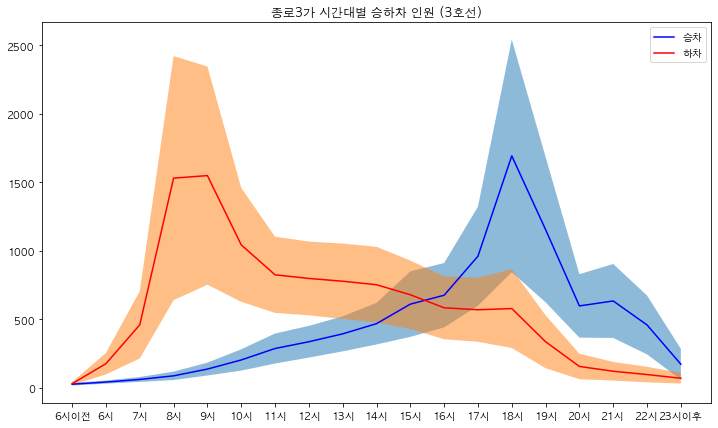

In [8]:
getinoff_stat_vis('종로3가', line='3호선')

## 위치별 승하차 인원 조사

In [9]:
daily_mean = subway[subway.columns[5:]].mean(axis=1)
subway_daily = subway[subway.columns[:5]]
subway_daily['하루사용자'] = daily_mean
subway_daily["날짜"] = pd.to_datetime(subway_daily["날짜"])
subway_daily = subway_daily.drop(['역번호'], axis=1)
subway_daily= subway_daily.groupby(['날짜','역명',],as_index=False).mean()
subway_daily.fillna(0)
subway_daily.head()

/var/folders/6j/0h_fy8z91dd31gb69z3fwgrh0000gn/T/ipykernel_57676/3964224177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway_daily['하루사용자'] = daily_mean
/var/folders/6j/0h_fy8z91dd31gb69z3fwgrh0000gn/T/ipykernel_57676/3964224177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway_daily["날짜"] = pd.to_datetime(subway_daily["날짜"])


,날짜,역명,하루사용자
0,2019-01-01,가락시장,181.171053
1,2019-01-01,가산디지털단지,608.026316
2,2019-01-01,강남,1989.000000
3,2019-01-01,강남구청,185.631579
4,2019-01-01,강동,423.184211


In [10]:
subway_daily["날짜"].max() - subway_daily["날짜"].min()

Timedelta('973 days 00:00:00')

In [16]:
subway_pivot = subway_daily.pivot(index="날짜", columns=['역명'], values='하루사용자')
subway_pivot = subway_pivot.resample('M').mean()
subway_pivot = subway_pivot.fillna(0)
subway_pivot.head()

역명,가락시장,가산디지털단지,강남,강남구청,강동,강동구청,강변(동서울터미널),강일,개롱,개화산,...,한양대,합정,행당,혜화,홍대입구,홍제,화곡,화랑대(서울여대입구),회현(남대문시장),효창공원앞
날짜,,,,,,,,,,,,,,,,,,,,,
2019-01-31,494.185059,2167.214771,5679.322581,828.368421,964.785229,565.172326,2309.906621,0.0,357.332767,306.359932,...,443.685059,1289.218166,419.353141,2181.466893,4289.223260,954.482173,1486.539898,556.278438,1579.545840,352.131579
2019-02-28,448.819079,1953.688910,5172.897556,750.767857,906.559211,518.263158,2367.253759,0.0,333.990602,287.057331,...,389.783835,1222.264568,393.734962,2020.181391,4330.056391,912.824248,1410.096805,522.796053,1477.139098,331.197368
2019-03-31,486.065789,2068.718166,5262.926995,826.343803,998.994907,556.434635,2379.286078,0.0,374.526316,312.421902,...,745.358234,1316.302632,433.084041,2229.728353,4504.499151,1042.916808,1540.046689,630.717317,1717.646859,388.798812
2019-04-30,508.178070,2205.585088,5293.689474,869.378947,1038.601754,579.587719,2401.171053,0.0,394.620175,327.546491,...,789.774561,1331.776754,452.979825,2242.370175,4328.227193,1081.718421,1616.010526,659.528947,1795.761404,411.717544
2019-05-31,489.547963,2123.962649,5272.370968,852.430390,1028.724109,570.657046,2470.529711,0.0,388.805603,325.943124,...,764.394737,1343.201613,443.904075,2356.587436,4544.016129,1073.095925,1600.068761,667.067063,1776.963497,398.378608


In [17]:
name_of_stations = list(subway_pivot.columns)

datetime_list = list()
datetime_int = list()
station_name_list = list()
lng = list()
lat = list()
value_list = list()
err = list()

for n in name_of_stations:
    dataindex = list(subway_pivot[n].index.values)
    dataindex2 = [int(str(i)[:10][:4]+str(i)[:10][5:7]+str(i)[:10][8:10]) for i in list(subway_pivot[n].index.values)]
    value_temp = list(subway_pivot[n])

    datetime_list += dataindex
    datetime_int += dataindex2
    value_list += value_temp
    station_name_list += [n for i in range(len(dataindex))]
    lng += [station_coords[n][1] for i in range(len(dataindex))]
    lat += [station_coords[n][0] for i in range(len(dataindex))]
        

df = pd.DataFrame()
df['datetime_int'] = datetime_int
df['datetime'] = datetime_list
df['역명'] = station_name_list
df['유동인구'] = value_list
df['lng'] = lng
df['lat'] = lat

In [28]:
df.head()

,datetime_int,datetime,역명,유동인구,lng,lat,color
0,20190131,2019-01-31,가락시장,494.185059,127.118234,37.492522,"[255, 494.18505942275056, 255, 255]"
1,20190228,2019-02-28,가락시장,448.819079,127.118234,37.492522,"[255, 448.8190789473685, 255, 255]"
2,20190331,2019-03-31,가락시장,486.065789,127.118234,37.492522,"[255, 486.06578947368405, 255, 255]"
3,20190430,2019-04-30,가락시장,508.178070,127.118234,37.492522,"[255, 508.1780701754386, 255, 255]"
4,20190531,2019-05-31,가락시장,489.547963,127.118234,37.492522,"[255, 489.54796264855696, 255, 255]"


/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_te

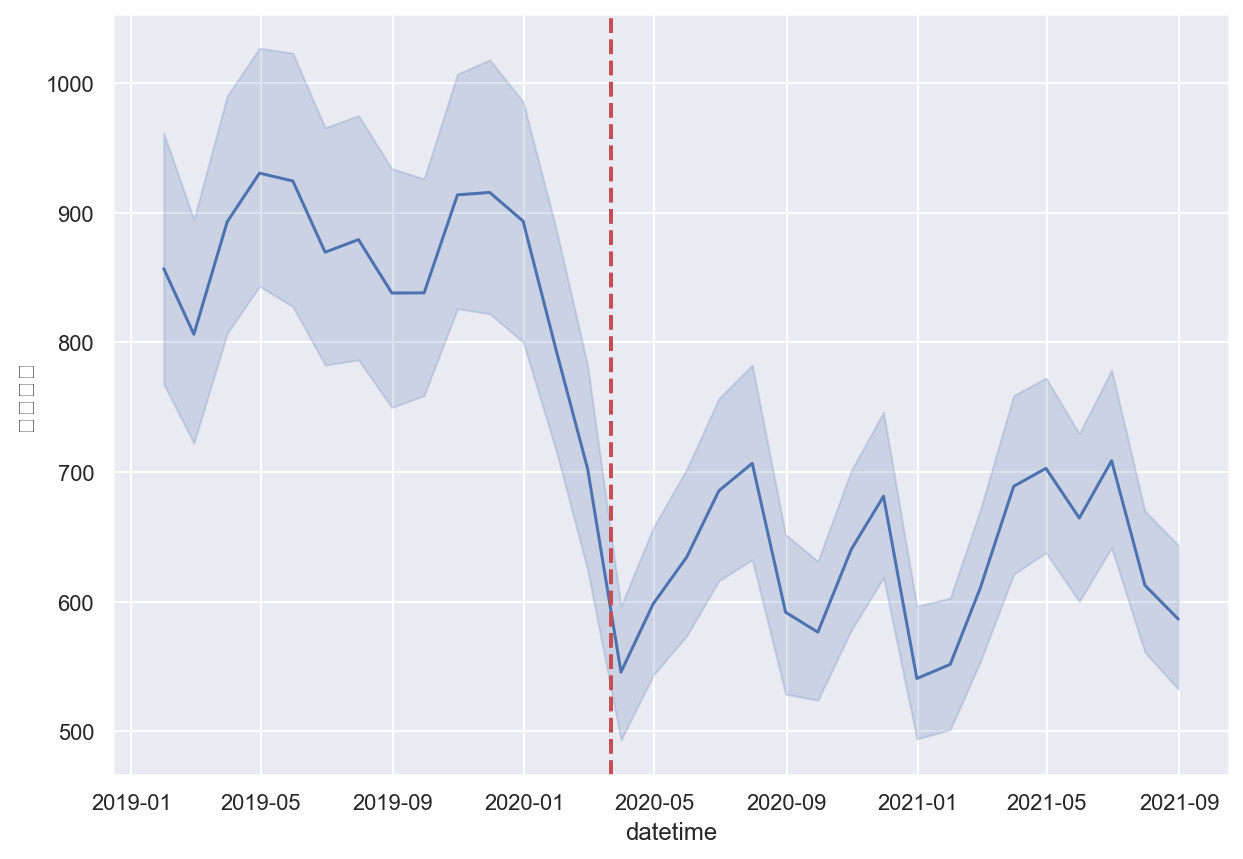

In [78]:
import seaborn as sns
import matplotlib.font_manager as fm
from datetime import datetime
from IPython.display import set_matplotlib_formats

plt.figure(figsize=(10,7))
sns.set_theme(style="darkgrid")
g = sns.lineplot(x="datetime", y="유동인구",data=df)
plt.axvline(x=datetime(2020, 3, 22), color='r', linestyle='--', linewidth=2)

In [77]:
df['color'] = df['유동인구'].apply(lambda val: [255, val,  255, 255])
plottable = df[df['datetime'] == '2019-01-31'].to_dict(orient='records')

view_state = pdk.ViewState(
      latitude=37.552987,
      longitude=126.972592,
      zoom=10.1,
      max_zoom=8,
      min_zoom=8)

scatterplot = pdk.Layer(
      'HeatmapLayer',
      data=plottable,
      get_position='[lng, lat]',
      get_weight='유동인구',
      opacity=0.5,
      pickable=False,
      elevation_scale=50,
      get_radius=25)

r = pdk.Deck(
      layers=[scatterplot],
      initial_view_state=view_state,
      views=[pdk.View(type='MapView', controller=None)])

r.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{"initialViewState": {"lat…

In [25]:
import time

def update(v):
    results = df[df['datetime_int'] == v].to_dict(orient='records')
    scatterplot.data = results
    r.update()
    
for i in df['datetime_int'].unique():
    time.sleep(1)
    update(i)

In [26]:
# Widget 슬라이더 생성
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(df['datetime_int'].min(), min=df['datetime_int'].min(), max=df['datetime_int'].max(), step=1)

# Widget에서 사용할 함수 정의 
def on_change(v):
    results = df[df['datetime_int'] == slider.value].to_dict(orient='records')
    scatterplot.data = results
    r.update()

# Deck과 슬라이더 연결
slider.observe(on_change, names='value')
display(slider)

IntSlider(value=20210101, max=20210827, min=20210101)

In [29]:
df['datetime_int'].unique()

array([20210101, 20210115, 20210129, 20210212, 20210226, 20210312,
       20210326, 20210409, 20210423, 20210507, 20210521, 20210604,
       20210618, 20210702, 20210716, 20210730, 20210813, 20210827])

## Folium 으로 시각화

In [147]:
m = folium.Map([37.55, 126.97], zoom_start=12, tiles = "cartodbpositron",) 
m

In [183]:
#time_index = 

import numpy as np

m0 = folium.Map([37.55, 126.97], zoom_start=12, tiles = "cartodbpositron",) 
location_data=df[['lat','lng']].values.tolist()
location_data = np.array(location_data) + np.random.normal(0,0.001, size=np.array(location_data).shape)
time_ind = df['datetime'].unique()
plugins.HeatMap(location_data, radius=20, opacity=0.2,
               max_val=1).add_to(m0) 
m0.save(os.path.join('./results/Heatmap.html'))
m0

/var/folders/6j/0h_fy8z91dd31gb69z3fwgrh0000gn/T/ipykernel_57676/4239593390.py:9: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  plugins.HeatMap(location_data, radius=20, opacity=0.2,


In [184]:
#time_index = 

m1 = folium.Map([37.55, 126.97], zoom_start=12, tiles = "cartodbpositron",) 

location_data_time=list()

for t in df['datetime'].unique():
    location_data=df[['lat','lng']].values.tolist()
    location_data_time.append(location_data)
location_data_time = np.array(location_data_time) + np.random.normal(0,0.001, size=np.array(location_data).shape)
time_ind = [str(i)[:10] for i in df['datetime'].unique()]

plugins.HeatMapWithTime(location_data_time, index = time_ind, 
                        auto_play=True).add_to(m1) 
m1.save(os.path.join('./results/HeatmapWithTime.html'))
m1